<a href="https://colab.research.google.com/github/soyoonjeong/STUDY/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import glob
import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [3]:
class VictorianDataset(Dataset):
  def __init__(self, root, color_transforms_ = None, gray_transforms_ = None):
    self.color_transforms = transforms.Compose(color_transforms_)
    self.gray_transforms = transforms.Compose(gray_transforms_)
    self.gray_files = sorted(glob.glob(os.path.join(root, 'gray') + "/*.*"))
    self.color_files = sorted(glob.glob(os.path.join(root, 'resized')+ "/*.*"))

  def __getitem__(self, index):
    gray_img = Image.open(self.gray_files[index % len(self.gray_files)]).convert('L')
    color_img = Image.open(self.color_files[index%len(self.color_files)]).convert('RGB')

    gray_img = self.gray_transforms(gray_img)
    color_img = self.color_transforms(color_img)

    return {'A' : gray_img, 'B' : color_img}

  def __len__(self):
    return len(self.gray_files)

In [4]:
train_root = '/content/drive/MyDrive/dataset/Victorian400 new/train/'
test_root = '/content/drive/MyDrive/dataset/Victorian400 new/val/'

img_height = 256
img_width = 256

batch_size = 12
test_batch_size = 6

gpu = 0

In [5]:
color_mean = [0.58090717, 0.52688643, 0.45678478]
color_std = [0.25644188, 0.25482641, 0.24456465]
gray_mean = [0.5350533]
gray_std = [0.25051587]

color_transforms_ = [
    transforms.Resize(size = (img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean = color_mean, std = color_std)
]

gray_transforms_ = [
    transforms.Resize(size = (img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean = gray_mean, std = gray_std)
]

In [6]:
train_loader = DataLoader(
    VictorianDataset(train_root, color_transforms_ = color_transforms_, gray_transforms_= gray_transforms_),
    batch_size = batch_size,
    shuffle = True
)

In [7]:
def reNormalize(img, mean, std):
  img = img.numpy().transpose(1, 2, 0)
  img = img * std + mean
  img = img.clip(0, 1)
  return img

torch.Size([12, 1, 256, 256]) torch.Size([12, 3, 256, 256])


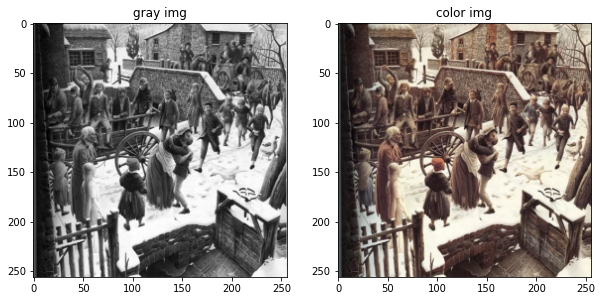

In [8]:
fig = plt.figure(figsize=(10,5))
rows = 1 
cols = 2

for X in train_loader:
    
    print(X['A'].shape, X['B'].shape)
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(reNormalize(X["A"][0], gray_mean, gray_std).reshape(img_height, img_width), cmap='gray') 
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(reNormalize(X["B"][0], color_mean, color_std))
    ax2.set_title('color img')    

    plt.show()
    break

In [9]:
# !pip install split-folders

In [10]:
# import splitfolders

# splitfolders.ratio('/content/drive/MyDrive/dataset/Victorian400', output = '/content/drive/MyDrive/dataset/Victorian400 new', seed = 49, ratio = (.8, .2))

In [9]:
test_loader = DataLoader(
    VictorianDataset(test_root, color_transforms_ = color_transforms_, gray_transforms_ = gray_transforms_),
    batch_size = test_batch_size,
    shuffle = False
)


(in_channels: int, out_channels: int, kernel_size: _size_2_t, stride: _size_2_t = 1, padding: _size_2_t | str = 0, dilation: _size_2_t = 1, groups: int = 1, bias: bool = True, padding_mode: str = 'zeros', device: Any | None = None, dtype: Any | None = None) -> None

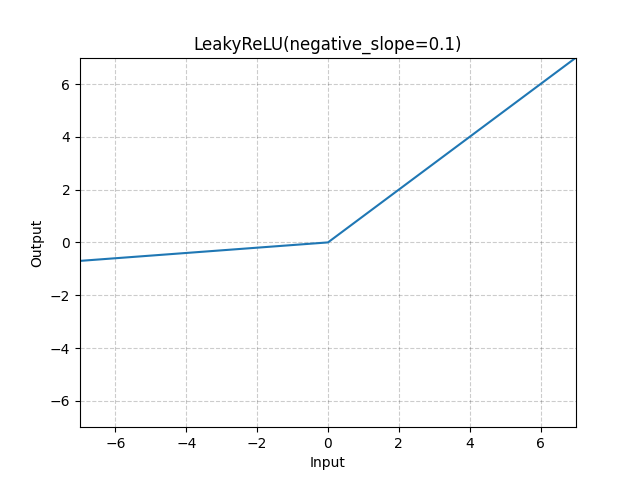

In [10]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(2, 64, 3, 1, 1), # in_channels, out_channels, kernel_size, stride, padding / padding 1은 feature map 크기 유지를 위해서
        nn.BatchNorm2d(64), # num_features
        nn.LeakyReLU(0.1), # 활성화함수로 leaky relu 
    )
    self.maxpool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Sequential(
        nn.Conv2d(64, 64 * 2, 3, 1, 1),
        nn.BatchNorm2d(64 * 2),
        nn.LeakyReLU(0.1)
    )
    self.upsample = nn.Sequential(
        nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1), # deconvolution layer, 여러 입력 평면으로 구성된 입력 이미지에 2D 전치 합성곱 연산자를 적용 
        nn.BatchNorm2d(64), 
        nn.LeakyReLU(0.1)
    )
    self.conv1by1 = nn.Sequential(
        nn.Conv2d(64, 64, 1, 1, 0), 
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.1)
    )
    self.conv = nn.Sequential(
        nn.Conv2d(64, 3, 3, 1, 1),
        nn.Tanh()
    )
  def forward(self, input):
    output1 = self.conv1(input)
    pool1 = self.maxpool(output1)
    output2 = self.conv2(pool1)
    output3 = self.upsample(output2) + output1
    output4 = self.conv1by1(output3)
    out = self.conv(output4)
    return out 

In [11]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        # feature map 크기 계산 : (I-F+2*P)/S+1
        nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False), # (256-4+2*1)/2 + 1 == 128
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False), # 64
        nn.BatchNorm2d(128),
         nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(128, 128, kernel_size = 1, stride = 1, padding = 0, bias = False), # 64
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False), # 32
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False), # 16
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(512, 1024, kernel_size = 4, stride = 2, padding = 1, bias = False), # 8
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(0.2, inplace = True),
    )
    self.fc = nn.Sequential(
        nn.Linear(1024 * 8 * 8, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, batch_size),
        nn.Sigmoid() # 

    )
  def forward(self, input, b_size):
    output = self.main(input)
    output = self.fc(output.view(b_size, -1))
    return output 

In [12]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    m.weight.data.normal_(0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    m.weight.data.normal_(1.0, 0.02)
    m.bias.data.fill_(0)

In [13]:
Gener = Generator().cuda(gpu) if torch.cuda.is_available() else Generator()
Gener.apply(weights_init)

Generator(
  (conv1): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (upsample): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (conv1by1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(nega

In [14]:
Discri = Discriminator().cuda(gpu) if torch.cuda.is_available() else Discriminator()
Discri.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, af

In [15]:
max_epoch = 50
optimizerD = torch.optim.Adam(Discri.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizerG = torch.optim.Adam(Gener.parameters(), lr = 0.0002, betas = (0.5, 0.999))

학습 단계(loop)에서 최적화는 세단계로 이뤄집니다:
- optimizer.zero_grad()를 호출하여 모델 매개변수의 변화도를 재설정합니다. 기본적으로 변화도는 더해지기(add up) 때문에 중복 계산을 막기 위해 반복할 때마다 명시적으로 0으로 설정합니다.

- loss.backwards()를 호출하여 예측 손실(prediction loss)을 역전파합니다. PyTorch는 각 매개변수에 대한 손실의 변화도를 저장합니다.

- 변화도를 계산한 뒤에는 optimizer.step()을 호출하여 역전파 단계에서 수집된 변화도로 매개변수를 조정합니다.

[Epoch 5/50] [Batch 27/27] [D loss : 0.070936] [G loss : 0.926454] ETA : 0:00:16.021110


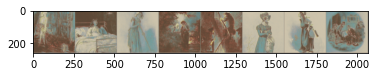

[Epoch 10/50] [Batch 27/27] [D loss : 0.732997] [G loss : 0.755656] ETA : 0:00:16.155195


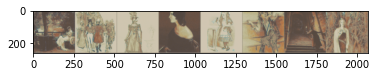

[Epoch 15/50] [Batch 27/27] [D loss : 0.006048] [G loss : 0.969217] ETA : 0:00:16.187895


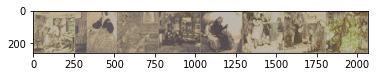

[Epoch 20/50] [Batch 27/27] [D loss : 0.000352] [G loss : 0.995116] ETA : 0:00:16.205072


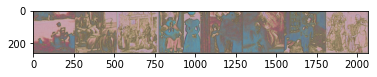

[Epoch 25/50] [Batch 27/27] [D loss : 0.002205] [G loss : 0.997653] ETA : 0:00:16.227614


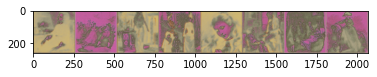

[Epoch 30/50] [Batch 27/27] [D loss : 0.000044] [G loss : 0.998263] ETA : 0:00:16.204186


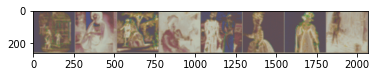

[Epoch 35/50] [Batch 27/27] [D loss : 0.047800] [G loss : 0.999985] ETA : 0:00:16.172296


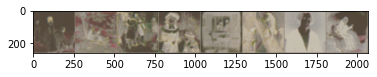

[Epoch 40/50] [Batch 27/27] [D loss : 0.000585] [G loss : 0.999959] ETA : 0:00:16.181482


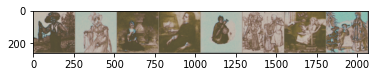

[Epoch 45/50] [Batch 27/27] [D loss : 0.077222] [G loss : 0.998419] ETA : 0:00:16.202670


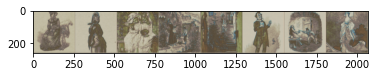

[Epoch 50/50] [Batch 27/27] [D loss : 0.000499] [G loss : 0.994828] ETA : 0:00:16.215061


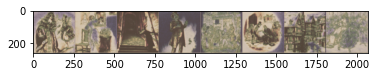

In [20]:
for epoch in range(max_epoch):
  start_time = datetime.datetime.now()
  loss_D = 0.0
  for i, data in enumerate(train_loader):
    grays, color = data['A'], data['B']
    b_size = len(data['A'])

    ####### 생성모델 (Generator) 학습 ######
    noise = torch.randn(b_size, 1, img_height, img_width).uniform_(0,1)
    gray_noise = Variable(torch.cat([grays, noise], dim = 1).cuda(gpu))
    fake_img = Gener(gray_noise)
    output = Discri(fake_img, b_size)
    g_loss = torch.mean((output-1)**2) # 바라는 답 == 1

    ######## 역전파 & 생성모델 최적화 #######
    Discri.zero_grad() 
    Gener.zero_grad()
    g_loss.backward() # 그레디언트 계산 
    optimizerG.step() # 수집된 그래디언트로 매개변수 조정

    ######## 판별모델 (Discriminator) 학습 ######
    color = Variable(color.cuda(gpu))
    noise = torch.randn(b_size, 1, img_height, img_width).uniform_(0,1)
    gray_noise = Variable(torch.cat([grays, noise], dim = 1).cuda(gpu))

    ######## 판별모델이 컬러 이미지를 진짜로 인식하도록 학습 ######
    output = Discri(color, b_size)
    real_loss = torch.mean((output-1)**2)

    ######## 판별모델이 흑백 이미지를 가가짜로 인식하도록 학습 ######
    fake_img = Gener(gray_noise)
    output = Discri(fake_img, b_size)
    fake_loss = torch.mean((output-0)**2)

    ######## 역전파 & 판별모델 최적화 #######
    d_loss = real_loss + fake_loss
    Discri.zero_grad()
    Gener.zero_grad()
    d_loss.backward()
    optimizerD.step()

    fake_img = torchvision.utils.make_grid(fake_img.data)

  epoch_time = datetime.datetime.now() - start_time
  if (epoch+1) % 5 == 0:
    torch.save(Gener.state_dict(), "/content/drive/MyDrive/dataset/Victorian400 new/generator_%d.pth" % (epoch+1))
    torch.save(Discri.state_dict(), "/content/drive/MyDrive/dataset/Victorian400 new/discriminator_%d.pth" % (epoch+1))
    print("[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f] ETA : %s" %(epoch+1, max_epoch, i+1, len(train_loader), d_loss.item(), g_loss.item(), epoch_time))
    plt.imshow(reNormalize(fake_img.cpu(), color_mean, color_std))
    plt.show()


In [16]:
Gener.load_state_dict(torch.load("/content/drive/MyDrive/dataset/Victorian400 new/generator_10.pth"))
Discri.load_state_dict(torch.load("/content/drive/MyDrive/dataset/Victorian400 new/discriminator_10.pth"))

<All keys matched successfully>

==================input==================


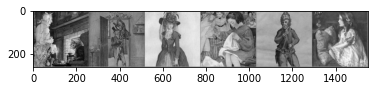

==================target==================


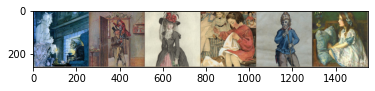

==================output==================


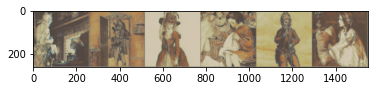

==================input==================


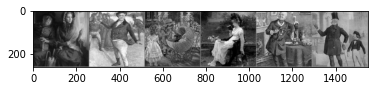

==================target==================


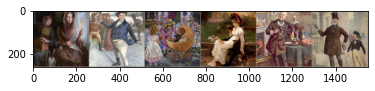

==================output==================


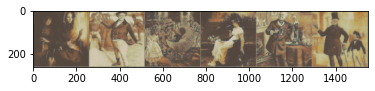

==================input==================


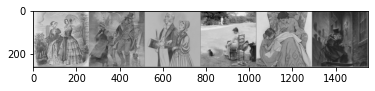

==================target==================


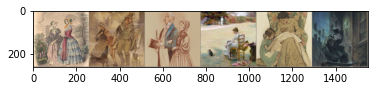

==================output==================


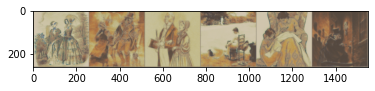

==================input==================


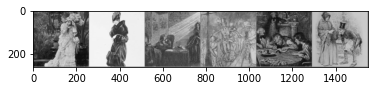

==================target==================


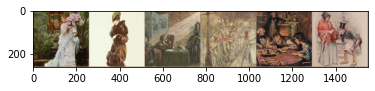

==================output==================


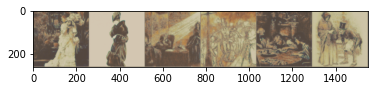

==================input==================


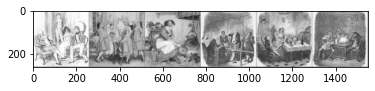

==================target==================


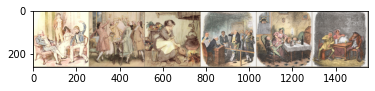

==================output==================


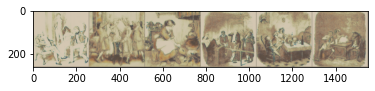

==================input==================


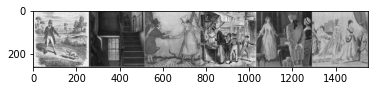

==================target==================


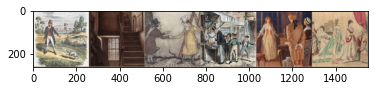

==================output==================


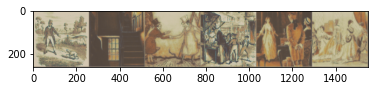

==================input==================


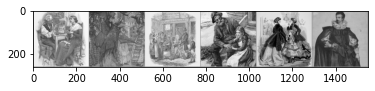

==================target==================


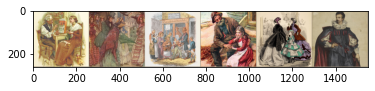

==================output==================


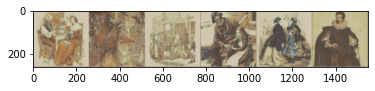

==================input==================


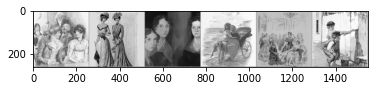

==================target==================


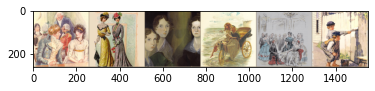

==================output==================


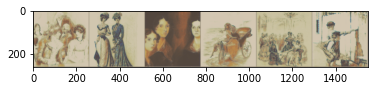

==================input==================


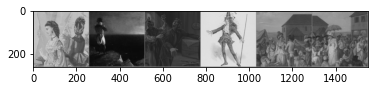

==================target==================


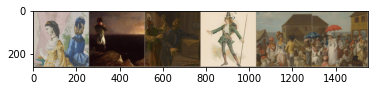

==================output==================


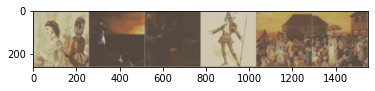

==================input==================


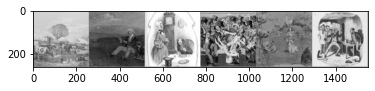

==================target==================


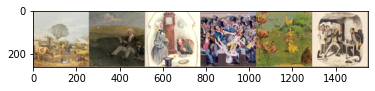

==================output==================


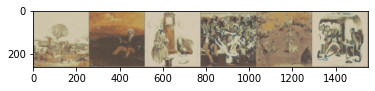

==================input==================


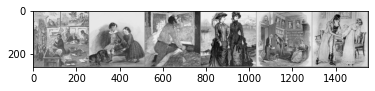

==================target==================


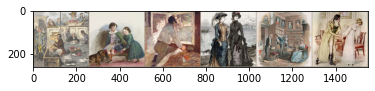

==================output==================


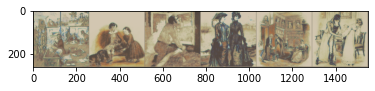

==================input==================


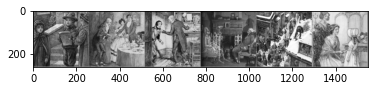

==================target==================


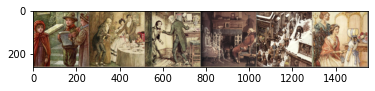

==================output==================


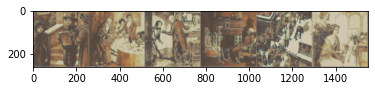

==================input==================


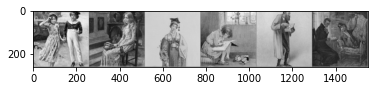

==================target==================


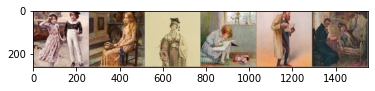

==================output==================


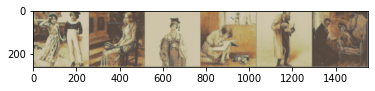

In [22]:
Discri.eval()
Gener.eval()

fixed_noise = torch.randn(test_batch_size, 1, img_height, img_width).uniform_(0,1)

for i, data in enumerate(test_loader, 0):
  images, label = data['A'], data['B']

  if len(data['A']) != test_batch_size:
    continue
  
  grays = torch.from_numpy(np.resize(images.numpy(), (test_batch_size, 1, img_height, img_width)))
  gray = Variable(torch.cat([grays, fixed_noise], dim = 1).cuda(gpu))

  output = Gener(gray)
  
  inputs = torchvision.utils.make_grid(grays)
  labels = torchvision.utils.make_grid(label)
  out = torchvision.utils.make_grid(output.data)

  print('==================input==================')
  plt.imshow(reNormalize(inputs.cpu(), gray_mean, gray_std))
  plt.show()
  print('==================target==================')
  plt.imshow(reNormalize(labels.cpu(), color_mean, color_std))
  plt.show()
  print('==================output==================')
  plt.imshow(reNormalize(out.cpu(), color_mean, color_std))
  plt.show()